In [ ]:
!pip install pysmiles 

  Using cached pbr-5.6.0-py2.py3-none-any.whl (111 kB)
  Created wheel for pysmiles: filename=pysmiles-1.0.1-py2.py3-none-any.whl size=22028 sha256=f6800f3ff2e89723028e7c258df1e731bec0e89c80fce622d728cc8cc3116718
  Stored in directory: /root/.cache/pip/wheels/e4/f0/ca/dae2e932684a6e26824d29cf5b6dadea7320e6fed036942972
Successfully built pysmiles


In [ ]:
!pip install torch_geometric

     |████████████████████████████████| 222 kB 14.7 MB/s 
     |████████████████████████████████| 376 kB 41.5 MB/s 
     |████████████████████████████████| 45 kB 2.9 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.7.2-py3-none-any.whl size=388142 sha256=de290a3fe76d4fa1f659428f4248418086eff3bb77e5840db349bb00b1b09512
  Stored in directory: /root/.cache/pip/wheels/55/93/b6/2eeb0465afe89aee74d7a07a606e9770466d7565abd45a99d5
Successfully built torch-geometric


In [ ]:
!pip install torch_sparse 

     |████████████████████████████████| 40 kB 4.6 MB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.11-cp37-cp37m-linux_x86_64.whl size=444203 sha256=b406ec9b02c1520ddfe862080ea7c6d2a516370b8a3ff4d71b29e43116fc7177
  Stored in directory: /root/.cache/pip/wheels/72/96/50/6d96633dcb6fa6afd1b210a4cdeb1fa30a400c352b88732a1f
Successfully built torch-sparse


In [ ]:
!pip install torch_scatter

  Created wheel for torch-scatter: filename=torch_scatter-2.0.8-cp37-cp37m-linux_x86_64.whl size=281098 sha256=c231739d83a9feb90fe32d57dbd9796cd3bebe3aca8d24236fbdafbaf9128e52
  Stored in directory: /root/.cache/pip/wheels/96/e4/4e/2bcc6de6a801960aedbca43f7106d268f766c3f9f8ab49b3a5
Successfully built torch-scatter


In [ ]:
import numpy as np
import pandas as pd 
import random
import matplotlib.pyplot as plt
from pysmiles import read_smiles
import pandas as pd
import logging
from tqdm import tqdm
import torch
from torch.nn import Sequential as Seq, Linear, ReLU, CrossEntropyLoss
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.utils import remove_self_loops, add_self_loops, degree
from torch_geometric.data import Data

logging.getLogger('pysmiles').setLevel(logging.CRITICAL)  # Anything higher than warning

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/curated-solubility-dataset.csv') #read dataset (https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OVHAW8)
X_smiles = list(df['SMILES']) #get smiles strings from file
Y = np.asarray(df['Solubility']) #get solubility values from file

elements = ['K', 'Y', 'V', 'Sm', 'Dy', 'In', 'Lu', 'Hg', 'Co', 'Mg',    #list of all elements in the dataset
            'Cu', 'Rh', 'Hf', 'O', 'As', 'Ge', 'Au', 'Mo', 'Br', 'Ce', 
            'Zr', 'Ag', 'Ba', 'N', 'Cr', 'Sr', 'Fe', 'Gd', 'I', 'Al', 
            'B', 'Se', 'Pr', 'Te', 'Cd', 'Pd', 'Si', 'Zn', 'Pb', 'Sn', 
            'Cl', 'Mn', 'Cs', 'Na', 'S', 'Ti', 'Ni', 'Ru', 'Ca', 'Nd', 
            'W', 'H', 'Li', 'Sb', 'Bi', 'La', 'Pt', 'Nb', 'P', 'F', 'C']

#convert element to a one-hot vector of dimension len(elements)
def element_to_onehot(element):
    out = []
    for i in range(0, len(element)):
        v = np.zeros(len(elements))
        v[elements.index(element[i])] = 1.0
        out.append(v)
    return np.asarray(out)

#convert solubility value to one-hot class vector
def val_to_class(val):
    if val < -3.65: #insoluble
        return [1, 0, 0]
    elif val < -1.69: #slightly soluble
        return [0, 1, 0]
    else: #soluble
        return [0, 0, 1]

#process SMILES strings into graphs
nodes = []
edge_index = []
for smiles in tqdm(X_smiles):
    try:
        G = read_smiles(smiles, explicit_hydrogen=True)
        feature = element_to_onehot(np.asarray(G.nodes(data='element'))[:, 1])
        edges = np.asarray(G.edges)
        index = np.asarray([edges[:,0], edges[:,1]]) #reshape indices into shape [2, -1]
        nodes.append(feature)
        edge_index.append(index)
    except:
        pass

100%|██████████| 9982/9982 [00:14<00:00, 670.44it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Generate Data objects
data = list()

#process graphs into torch_geometric Data objects
for i in tqdm(range(0, len(nodes))):
    x = torch.tensor(nodes[i], dtype=torch.float) #convert node features into torch tensor
    edges = torch.tensor(edge_index[i], dtype=torch.long) #convert edge index into torch tensor
    y = torch.tensor([val_to_class(Y[i])], dtype=torch.float) #change shape of label and convert to tensor
    data.append(Data(x=x,edge_index=edges, y=y)) #add the Data object to the list of data
random.shuffle(data)
train = data[:int(len(data)*0.8)] #train set
test = data[int(len(data)*0.8):] #val set
train = data

100%|██████████| 9946/9946 [00:00<00:00, 26226.73it/s]


In [ ]:
#define the message passing network
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(61, 32)
        self.conv2 = GCNConv(32, 32)
        self.conv3 = GCNConv(32, 32)
        self.conv4 = GCNConv(32, 32)
        self.lin1 = Linear(32, 16)
        self.lin2 = Linear(16, 3)

    def forward(self, data):
        x, edge_index= data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        
        x = torch.sum(x, dim=0)
        x = self.lin1(x)
        x = F.relu(x)
        
        x = self.lin2(x)
        

        return x

In [ ]:
#set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
model = Net().to(device) #create network and send to the device memory
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer
CSE = CrossEntropyLoss() #define loss

In [ ]:
#train model
model.train() #set model to training mode
for epoch in range(2): #run for epochs of training
    sum_loss = 0 #used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train) #shuffle the training data each epoch
    for d in tqdm(train): #go over each training point
        data = d.to(device) #send data to device
        optimizer.zero_grad() #zero gradients
        out = model(data) #evaluate data point
        if torch.argmax(out) == torch.argmax(data.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y),[1])) #compute mean squared error loss
        sum_loss += float(loss) #add loss value to aggregate loss
        loss.backward() #compute gradients
        optimizer.step() #apply optimization
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, sum_loss/len(train), num_correct/len(train)))

  0%|          | 25/9946 [00:00<00:39, 249.61it/s]

Epoch: 000, Average loss: 1.07927, Accuracy: 0.39433


100%|██████████| 9946/9946 [00:43<00:00, 226.61it/s]

Epoch: 001, Average loss: 1.06912, Accuracy: 0.41333


100%|██████████| 1990/1990 [00:04<00:00, 434.78it/s]

Test accuracy: 0.43417085427135677


(array([520., 951., 519.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <a list of 3 Patch objects>)

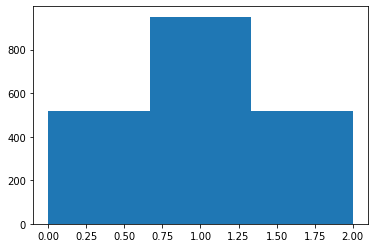

In [ ]:
#test the model and display a histogram of the outputs
num_correct = 0
model.eval()
predictions = list()
for t in tqdm(test):
    d = t.to(device)
    out = model(d)
    if torch.argmax(out) == torch.argmax(d.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
    predictions.append(torch.argmax(out).item())
    
print("Test accuracy: " + str(num_correct/len(test)))
plt.hist(predictions, bins=3)

In [ ]:
#test SMILES string
def evaluate_smiles(smiles_string):
    classes = ['insoluble', 'slightly soluble', 'soluble']
    G = read_smiles(smiles_string, explicit_hydrogen=True) #decode smiles string
    feature = element_to_onehot(np.asarray(G.nodes(data='element'))[:, 1]) #convert element to one-hot vector
    edges = np.asarray(G.edges) #get edge array
    index = np.asarray([edges[:,0], edges[:,1]]) #reformat edge array to torch geometric suitable format
    d = Data(x=torch.tensor(feature, dtype=torch.float),edge_index=torch.tensor(index, dtype=torch.long)) #create torch gemoetry Data object
    data = d.to(device) #send data to device memory
    model.eval() #set model to evaluate mode
    print(classes[torch.argmax(torch.softmax(model(data), dim=0)).item()]) #evaluate the test data

In [ ]:
evaluate_smiles('C1:C:C:C2:C(:C:1):C:C:C1:C:2:C:C:C2:C3:C:C:C:C:C:3:C:C:C:2:1') #test out the model on Vitamin C

insoluble
